In [1]:
import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [3]:
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [4]:
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
from items import Item

In [6]:
with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [7]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [8]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

## Random Forest

In [9]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [9]:
rf_model = joblib.load('random_forest_model.pkl')

In [10]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [11]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [12]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [14]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $292.90 Truth: $374.41 Error: $81.51 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $199.72 Truth: $225.11 Error: $25.39 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $212.74 Truth: $61.68 Error: $151.06 SLE: 1.50 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $372.57 Truth: $599.99 Error: $227.42 SLE: 0.23 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $204.66 Truth: $16.99 Error: $187.67 SLE: 5.94 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $56.24 Truth: $31.99 Error: $24.25 SLE: 0.30 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $274.87 Truth: $101.79 Error: $173.08 SLE: 0.97 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $230.83 Truth: $289.00 Error: $58.17 SLE: 0.05 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $318.68 Truth: $635.86 Error: $317.18 SLE: 0.48 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $175.94 Truth: $65.99 Error: $109.95 SLE

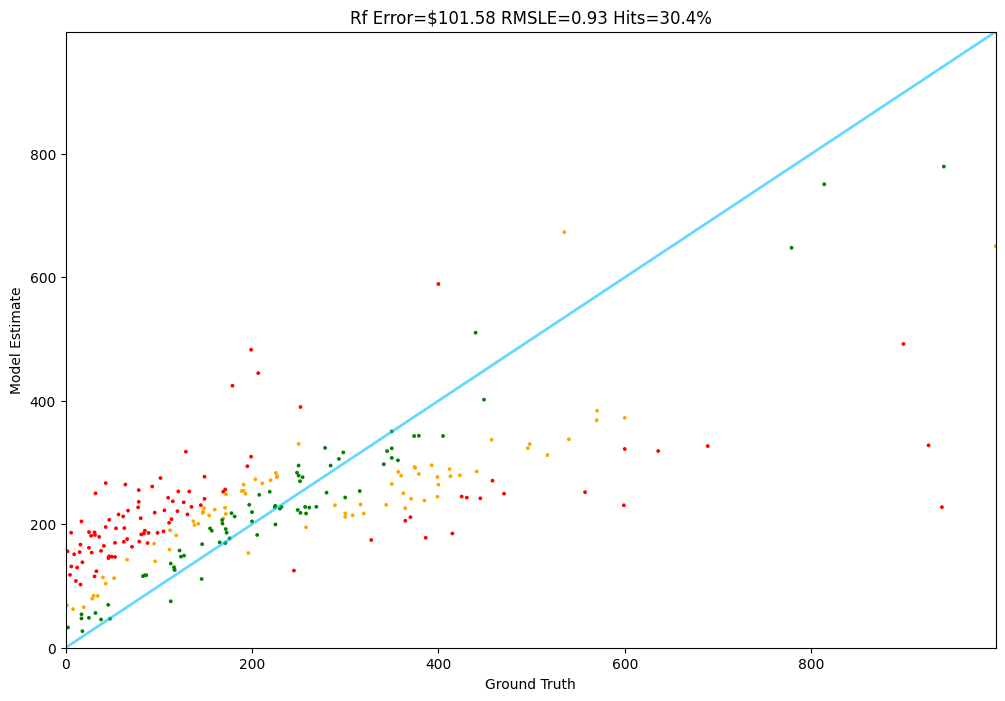

In [15]:
Tester.test(rf, test)

In [16]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [17]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

189.0
195.19
293.20660000000026


In [18]:
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|██████████| 250/250 [11:55<00:00,  2.86s/it]


In [19]:
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [20]:
# Train a Linear Regression
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.38
Frontier: 0.11
RandomForest: -0.50
Min: 0.54
Max: 0.45
Intercept=27.67


In [21]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [22]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [23]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $414.10 Truth: $374.41 Error: $39.69 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $206.00 Truth: $225.11 Error: $19.11 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $49.51 Truth: $61.68 Error: $12.17 SLE: 0.05 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $385.42 Truth: $599.99 Error: $214.57 SLE: 0.20 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $36.21 Truth: $16.99 Error: $19.22 SLE: 0.53 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $40.28 Truth: $31.99 Error: $8.29 SLE: 0.05 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $108.20 Truth: $101.79 Error: $6.41 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $371.78 Truth: $289.00 Error: $82.78 SLE: 0.06 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $891.19 Truth: $635.86 Error: $255.33 SLE: 0.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $74.03 Truth: $65.99 Error: $8.04 SLE: 0.01 Ite

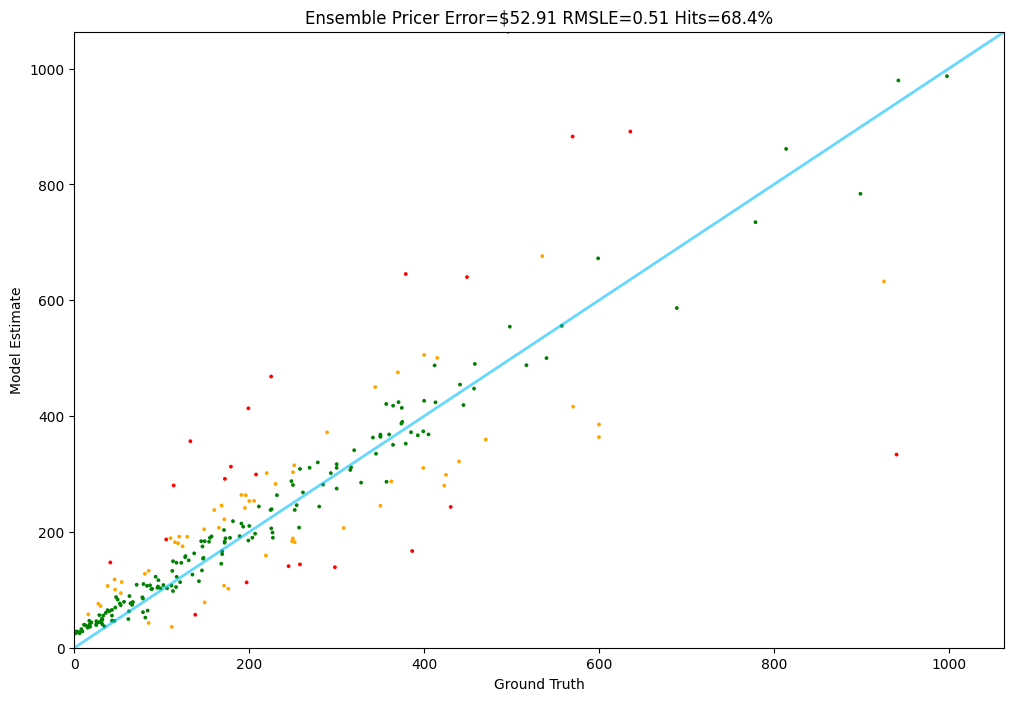

In [24]:
Tester.test(ensemble_pricer, test)